![Banner logo](../../fig/citrine_banner.png)

# Introduction to Queries
*Authors: Max Hutchinson, Carena Church, Enze Chen*

In this notebook, we will introduce the query language and [`SearchClient`](http://citrineinformatics.github.io/python-citrination-client/tutorial/search_examples.html) that allows you to search and download PIFs from Citrination. By basing scripts on queries instead of local files, you can:   
1. Share data with your group without running internal infrastructure or worrying about portability.
1. Expand your queries to include data uploaded by other groups in your field.
1. Publish post-processing scripts backed by Citrination data to improve reproducibility.

*Note*: The query language is quite sophisticated, and we cannot cover every use case here.

## Learning outcomes
By the end of this notebook, you will know how to:
* Search for and return PIFs using PyCC.
* Include filters and extract data from queries.

## Background knowledge
In order to get the most of out of this notebook, you should already be familiar with:
* The structure of the Physical Information File, or **PIF** (see the [Intro](WorkingWithPIFs.ipynb) and [Advanced](AdvancedPIF.ipynb) tutorials).
* The basics of the **Python Citrination Client (PyCC)** (see [docs](http://citrineinformatics.github.io/python-citrination-client/tutorial/tutorial.html)).

## Python package imports

In [1]:
# Standard packages
import os
import re

# Third-party packages
from citrination_client import CitrinationClient
from citrination_client import PifSystemReturningQuery, PifSystemQuery
from citrination_client import DataQuery, DatasetQuery, ChemicalFieldQuery
from citrination_client import PropertyQuery, FieldQuery
from citrination_client import ChemicalFilter, Filter

from pypif import pif
from dfttopif import directory_to_pif
from pypif_sdk.readview import ReadView
import matplotlib.pyplot as plt
%matplotlib inline

## Query interfaces

There are multiple interfaces to a unified backend based on elastic search:
1. The [Citrination website](https://citrination.com/).
1. The Python and Java Citrination Clients.
1. A REST API.
 
This tutorial will focus on the **Python Citrination Client**. See our [API docs](https://citrineinformatics.github.io/api-documentation/#tag/search) for more information.

### Client initialization
We will assume you're already familiar with the standard procedure of storing API Keys in your environment variables. After the main Python client is initialized, the `SearchClient` is easily accessed as an attribute.

In [2]:
site = 'https://citrination.com' # public
client = CitrinationClient(api_key=os.environ['CITRINATION_API_KEY'], site=site)
search_client = client.search

### `PifSystemReturningQuery`

Each search and download request is stored in a query object: the `PifSystemReturningQuery`. As an example, a `PifSystemReturningQuery` can be structured in the following hierarchical way:

```
PifSystemReturningQuery(
    size=0,
    query=DataQuery(
        dataset=DatasetQuery(
            id=Filter(equal='151278')),
            system=PifSystemQuery(
                chemical_formula=ChemicalFieldQuery(
                    filter=ChemicalFilter(
                        equal='C22H15NSSi')))))
```

### `pif_search`
The query object created above can be passed into the `pif_search()` method, which returns a `PifSearchResult` object with the following properties:
* `took`: Number of milliseconds the query took to execute.
* `total_num_hits`: Total number of hits.
* `max_score`: The maximum score.
* `hits`: List of `PifSearchHit` objects.

If you are working through the notebooks in the order they are presented in our [README](README.md), use the `dataset_id` from the previous Importing VASP calculations notebook in the query below. 

Otherwise, we can start with the [Band gaps from Strehlow and Cook dataset](https://citrination.com/datasets/1160/show_search) (ID: 1160), but feel free to use any public dataset.

In [3]:
# Change dataset id below
dataset_id = 1160
system_query = PifSystemReturningQuery(size=5, 
                                       query=DataQuery(
                                           dataset=DatasetQuery(
                                               id=Filter(
                                                   equal=str(dataset_id)))))

query_result = search_client.pif_search(system_query)
print("Found {} PIFs in dataset {}.".format(query_result.total_num_hits, dataset_id))

Found 1449 PIFs in dataset 1160.


The result contains the matching PIFs, which can be extracted from the `system` field in each `PifSearchHit`:

In [4]:
pifs = [x.system for x in query_result.hits]
print(pif.dumps(pifs[0], indent=2)[:500])
print('... ommitted for space ...')

{
  "category": "system.chemical",
  "references": [
    {
      "doi": "10.1063/1.3253115"
    }
  ],
  "uid": "005C55AA25FC107362DB3D17F7A2B30F",
  "properties": [
    {
      "name": "Crystallinity",
      "scalars": [
        {
          "value": "Single crystalline"
        }
      ]
    },
    {
      "name": "Band gap",
      "scalars": [
        {
          "value": "0.153"
        }
      ],
      "units": "eV",
      "conditions": [
        {
          "name": "Temperature",
          
... ommitted for space ...


### Simple chemical search
The `generate_simple_chemical_query()` method can accept lists of datasets to aggregate data from collaborators and generate a `PifSystemReturningQuery` object.

In [5]:
my_dataset_id = 154987
another_dataset_id = 1160
simple_query = search_client.generate_simple_chemical_query(include_datasets=[my_dataset_id, another_dataset_id], 
                                                            size=500)
query_result = search_client.pif_search(simple_query)
print("Found {} PIFs in datasets {} and {}.".format(query_result.total_num_hits, 
                                                    my_dataset_id, another_dataset_id))

Found 1451 PIFs in datasets 154987 and 1160.


## Real example: Phase stability diagram
We return to the running example through the tutorial sequence. There are surely more Al-Cu binaries on Citrination.  We will:
1. Find relevant data via the web interface.
1. Filter the data programatically with the query.
1. Extract the data using query extractions.
1. Add the data to our plot from before.

## Search for relevant data: The power of filters
Now that we are querying beyond just our data, we need to filter down to records that contain Al-Cu energies. The exploratory search is usually best done on the website.  Tips and tricks:
 * "AlxCuy" searches for any Al-Cu binary in any stoichiometry.
 * "energy" searches for properties with "energy" in their name.

### Filter by chemical formula
We will try two different types of queries, the first one where we filter compounds in a specific dataset that have the formula `AlxCuy`. To do this, we will use the `ChemicalFilter`. You'll also notice that we have used a `Filter` on the `id` field, as we did previously, to restrict our search to a specific dataset.

In [6]:
# Filtering over a known dataset by chemical formula AlxCuy
filter_formula = 'AlxCuy'
dataset_id = 1160
system_query = PifSystemReturningQuery(
                size=0,
                query=DataQuery(
                    dataset=DatasetQuery(
                        id=Filter(equal=dataset_id)),
                    system=PifSystemQuery(
                        chemical_formula=ChemicalFieldQuery(
                            filter=ChemicalFilter(equal=filter_formula)))))
query_result = search_client.pif_search(system_query)
print('The query in dataset {} with filter formula {} returned {} hits.'.format(dataset_id,
                                                                                filter_formula,
                                                                                query_result.total_num_hits))

The query in dataset 1160 with filter formula AlxCuy returned 0 hits.


We will then try to find `AlxCuy` compounds in all public datasets on Citrination.

In [7]:
# Filtering over all datasets by chemical formula AlxCuy
system_query = PifSystemReturningQuery(
            size=10,
            query=DataQuery(simple=filter_formula))
query_result = client.search.pif_search(system_query)
print('The query found {} PIFs with the formula {}.'.format(query_result.total_num_hits, filter_formula))

The query found 241 PIFs with the formula AlxCuy.


### Filter by property
We can do quick, filtered searches with the `generate_simple_chemical_query()`. It returns a `PifSearchResult` object as before, but with useful filter flags. See the docs for more info.

In [8]:
simple_query1 = search_client.generate_simple_chemical_query(property_name='Formation Energy', 
                                                             chemical_formula='AlxCuy', size=500)
quick_search1 = search_client.pif_search(simple_query1)
print("Found {} PIFs.".format(quick_search1.total_num_hits))

simple_query2 = search_client.generate_simple_chemical_query(property_name=['Formation Energy', 'Enthalpy of Formation'], 
                                                             chemical_formula='AlxCuy', size=500)
quick_search2 = search_client.pif_search(simple_query2)
print("Found {} PIFs.".format(quick_search2.total_num_hits))

Found 21 PIFs.
Found 32 PIFs.


In [9]:
print(pif.dumps(quick_search1.hits[0].system, indent=4)[:300])
print('... ommitted for space ...')

{
    "category": "system.chemical",
    "references": [
        {
            "doi": "10.1016/j.commatsci.2012.02.002"
        },
        {
            "doi": "10.1016/j.commatsci.2012.02.005"
        }
    ],
    "uid": "0736FD37BB740E1887922CDE86239C43",
    "properties": [
        {
            
... ommitted for space ...


## Extract data from results using the query language
Multiple sources typically use multiple internal formats. The query language is smart about crawling the PIFs for properties with the right names, while `pypif` is not. Fortunately, you can use the query language to do data extraction as well!

### Using `extract_as`
The `extract_as` parameter in `FieldQuery` is a string representing the alias to save the field under. It is helpful when searching across multiple datasets that use different names for the same property.

In [10]:
system_query = PifSystemReturningQuery(
            size=500,
            query=DataQuery(
                system=PifSystemQuery(
                    chemical_formula=ChemicalFieldQuery(
                        extract_as="formula",
                        filter=ChemicalFilter(equal='AlxCuy')),
                    properties=PropertyQuery(
                        name=FieldQuery(
                            filter=[Filter(equal="Formation energy"), Filter(equal="Enthalpy of Formation")]),
                        value=FieldQuery(
                            extract_as="formation_enthalpy")))))

query_result = client.search.pif_search(system_query)
print("Found {} PIFs.".format(query_result.total_num_hits))
print([x.extracted for x in query_result.hits][0:2])

Found 32 PIFs.
[{'formation_enthalpy': '-0.1889', 'formula': 'Cu3Al'}, {'formation_enthalpy': '-0.1799', 'formula': 'CuAl2'}]


A few notes:
 * `extract_as` extracts the field it is on (why we need value).
 * `extracted` is a dictionary from String keys to values; no units or uncertainty.

## Real example: Phase stability diagram

Let's create an Al-Cu phase diagram and add these points.

We'll start with some sample DFT data and create PIFs out of the samples. Then, we'll add the new points found in our query above.

In [11]:
# Use helper function to get data (might take a minute to finishing running)
Cu_pif = directory_to_pif("./example_data/Cu.cF4")
Al_pif = directory_to_pif("./example_data/Al.cF4")
AlCu_pifs = [directory_to_pif(os.path.join("./example_data/", x))
             for x in os.listdir("./example_data/") if "Al" in x]

In [12]:
def enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu):
    return (energy - n_Al * energy_Al - n_Cu * energy_Cu) / (n_Al + n_Cu)

In [13]:
def get_stoich(AlCu_formula):
    m = re.match(r"Al([0-9]*)Cu([0-9]*)", AlCu_formula)
    if m is not None:
        n_Al = float(m.group(1)) if len(m.group(1)) > 0 else 1
        n_Cu = float(m.group(2)) if len(m.group(2)) > 0 else 1
        return (n_Al, n_Cu)
    m = re.match(r"Cu([0-9]*)Al([0-9]*)", AlCu_formula)
    if m is not None:
        n_Cu = float(m.group(1)) if len(m.group(1)) > 0 else 1
        n_Al = float(m.group(2)) if len(m.group(2)) > 0 else 1
        return (n_Al, n_Cu)
    return (0, 0)

`ReadView` is a dictionary-like read-only view into a PIF that indexes members by name and elevates keys up the PIF hierarchy as long as they are unambiguous. For more information, see the [source code](https://github.com/CitrineInformatics/pypif-sdk/blob/develop/pypif_sdk/readview/core.py).

Here, we'll use `ReadView` to populate an array of `(Energy, formula)` tuples to build our phase diagram.

In [14]:
energy_Al = ReadView(Al_pif)["Total Energy"].scalars[0].value / 4
energy_Cu = ReadView(Cu_pif)["Total Energy"].scalars[0].value

points = [(0.0, 0.0), (1.0, 0.0)]
for pif in AlCu_pifs:
    rv = ReadView(pif)
    energy = rv["Total Energy"].scalars[0].value
    n_Al, n_Cu = get_stoich(rv.chemical_formula)
    if n_Al == 0 and n_Cu == 0: continue
    data_point = (n_Cu / (n_Cu + n_Al), enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu))
    points.append(data_point)

Now, let's add the new points from our queries above. 

In [15]:
new_points = []
for hit in query_result.hits:
    n_Al, n_Cu = get_stoich(hit.extracted["formula"])
    new_points.append((n_Cu / (n_Cu + n_Al), float(hit.extracted["formation_enthalpy"])))

And then we will plot both sets of points, distinguishing them using different colors and labels.

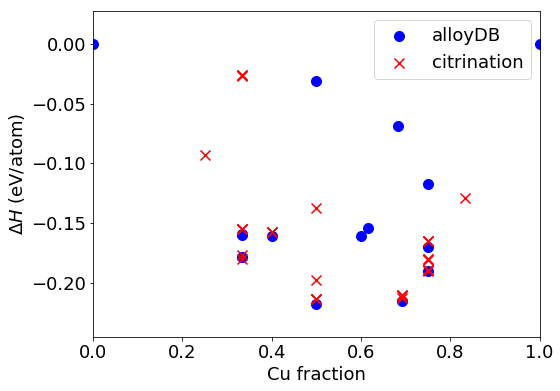

In [16]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': (8, 6), 'lines.markersize':10})
plt.scatter(*zip(*points), color='blue', marker='o', label='alloyDB')
plt.scatter(*zip(*new_points), color='red', marker='x', label='citrination')
plt.legend(loc="best")
plt.xlim(0, 1)
plt.xlabel("Cu fraction")
plt.ylabel("$\Delta H$ (eV/atom)")
plt.show()

### Filter by value
A few of the values in the data are mislabeled: They are called "Enthalpy of Formation," but are actually total energies (per atom). We can filter them out by recognizing that all the Al-Cu binaries have enthalpy of formation above $-1.0$ eV/atom.

In [17]:
system_query = PifSystemReturningQuery(
            size=500,
            query=DataQuery(
                system=PifSystemQuery(
                    chemical_formula=ChemicalFieldQuery(
                        extract_as="formula",
                        filter=ChemicalFilter(equal='AlxCuy')),
                    properties=PropertyQuery(
                        name=FieldQuery(
                            filter=[Filter(equal="Formation energy"), Filter(equal="Enthalpy of Formation")]),
                        value=FieldQuery(
                            extract_as="formation_enthalpy",
                            filter=[Filter(min=-1.0)])))))

query_result = search_client.pif_search(system_query)

In [18]:
new_points = []
for hit in query_result.hits:
    n_Al, n_Cu = get_stoich(hit.extracted["formula"])
    new_points.append((n_Cu / (n_Cu + n_Al), float(hit.extracted["formation_enthalpy"])))

This looks much better:

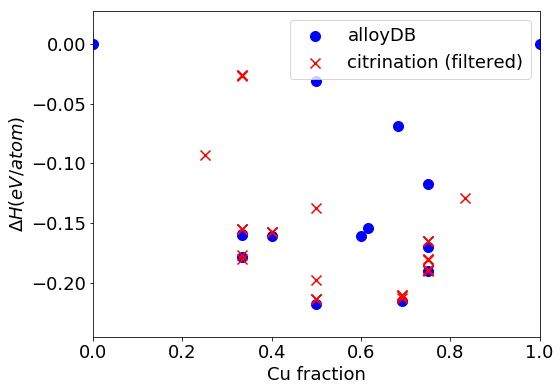

In [19]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': (8, 6), 'lines.markersize':10})
plt.scatter(*zip(*points), color='blue', marker='o', label='alloyDB')
plt.scatter(*zip(*new_points), color='red', marker='x', label='citrination (filtered)')
plt.legend()
plt.xlim(0, 1)
plt.xlabel("Cu fraction")
plt.ylabel("$\Delta H (eV/atom)$")
plt.show()

## Conclusion
This concludes the introduction to the query language and the `SearchClient`. We discussed how to return PIF systems from queries, and how to filter and extract the relevant content. At this point, you should be comfortable with:
* Searching for PIFs using the PyCC.
* Using filters to limit the scope of searches.
* Extracting data from queries across multiple datasets.

As a next step, check out our [Advanced tutorial on queries](AdvancedQueries.ipynb).